# GAN building of a model using 

In [1]:
!pip install tabgan

In [3]:
from tabgan.sampler import OriginalGenerator, GANGenerator
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
from PIL import Image

from tqdm import tqdm
import shutil

from pathlib import Path

import torch
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image

import glob
import os
import shutil

import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as L
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import nn
from torch.utils.data import DataLoader, dataset
from torchvision.io import read_image
from torchvision.utils import make_grid, save_image

import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers

cuda = True if torch.cuda.is_available() else False # GPU Setting


# this notebook was helped by https://www.kaggle.com/code/kuzinmaxim/ganmonet

# this notebook was helped by https://www.kaggle.com/code/garrettdevereux/uw-deep-learning-diffaug-dc-cyclegan


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/_ctgan/synthesizer.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

## In this notebook, we will aim to build a Generative Adversarial Network using the Monet images. GANs are models that create new data based on the trained data. When we use it with Monet's images, we are giving it information on what the image should be and then allowing it to create its own similar image that did not exist before. We will import the data for this competition project, do our data cleaning and preprocessing, exploratory data analysis, and then create our GAN.

In [5]:
#let us read in and store the data accordingly
data = '/kaggle/input/gan-getting-started'
print(data)

print(os.listdir(data))

monet_jpg = 'monet_jpg'
photo_jpg = 'photo_jpg'

/kaggle/input/gan-getting-started
['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']


In [6]:
class MonetPhoto(Dataset):
    def __init__(self, data, monet_jpg, photo_jpg, transform=None):
        self.data = data
        self.monet_jpg = monet_jpg
        self.monet_images = os.listdir(os.path.join(data, monet_jpg))
        self.photo_jpg = photo_jpg
        self.photo_images = os.listdir(os.path.join(data, photo_jpg))
        self.transform = transform

    def __len__(self):
        return max(len(self.monet_images), len(self.photo_images))

    def __getitem__(self, idx):
        monet_image = Image.open(os.path.join(data, monet_jpg, self.monet_images[idx % len(self.monet_images)]))
        photo_image = Image.open(os.path.join(data, photo_jpg, self.photo_images[idx % len(self.photo_images)]))
        if self.transform:
            monet_image = self.transform(monet_image)
            photo_image = self.transform(photo_image)
        return monet_image, photo_image

In [7]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

dataframe = MonetPhoto(data, monet_jpg, photo_jpg, transform=transforms)

In [8]:
len(dataframe)

7038

In [9]:
x, y = dataframe.__getitem__(1)

x.shape, y.shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [10]:
x.max(), x.min(), y.max(), y.min()

(tensor(1.), tensor(-1.), tensor(1.), tensor(-1.))

In [12]:
train_size, test_size = int(len(dataframe) * 0.8), len(dataframe) - int(len(dataframe) * 0.8)

In [13]:
train_data, test_data = random_split(dataframe, [train_size, test_size])

In [14]:
len(train_data)

5630

In [16]:
train_dl = DataLoader(train_data.dataset, batch_size=40, shuffle=True, num_workers=3)
test_dl = DataLoader(test_data.dataset, batch_size=40, shuffle=True, num_workers=3)

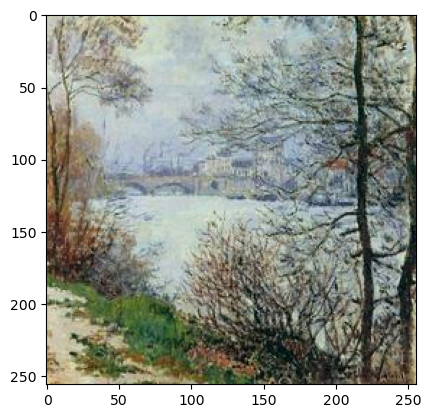

In [17]:
monets, photos = next(iter(train_dl))

plt.imshow(monets[0].permute(1, 2, 0).numpy() * 0.5 +0.5)

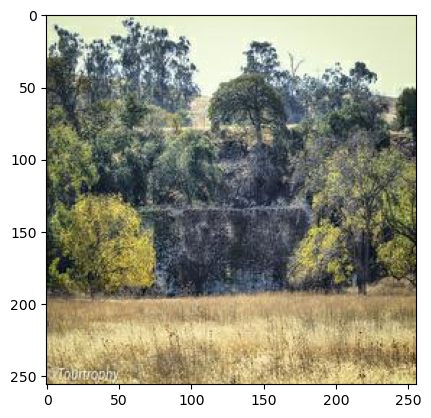

In [18]:
plt.imshow(photos[0].permute(1, 2, 0).numpy() * 0.5 +0.5)

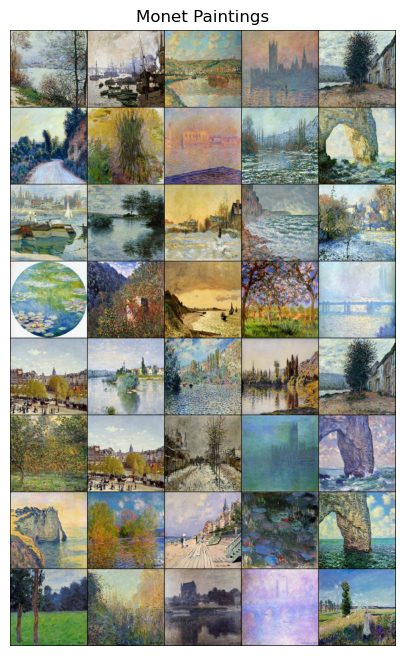

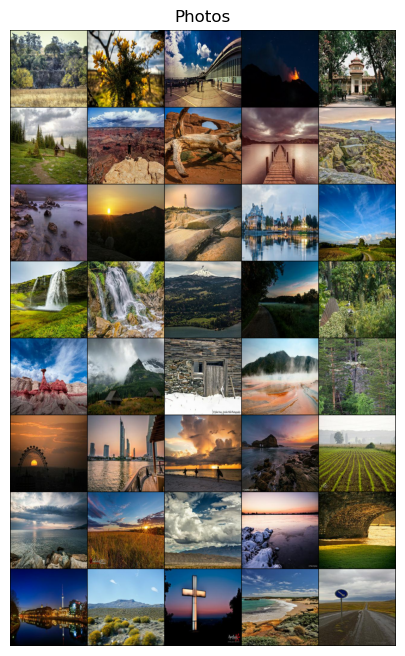

In [19]:
def show_img(img_tensor, nrow, title=""):
    img_tensor = img_tensor.detach().cpu() * 0.5 + 0.5
    img_grid = make_grid(img_tensor, nrow=nrow).permute(1, 2, 0)
    plt.figure(figsize=(18, 8))
    plt.imshow(img_grid)
    plt.axis("off")
    plt.title(title)
    plt.show()

show_img(monets, nrow=5, title="Monet Paintings")
show_img(photos, nrow=5, title="Photos")

In [20]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [21]:
latent_dim = 100 # suggested default

In [22]:
cuda = True if torch.cuda.is_available() else False # GPU Setting

In [23]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # inplace=True : modify the input directly. It can slightly decrease the memory usage.
            return layers # return list of layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Asterisk('*') in front of block means unpacking list of layers - leave only values(layers) in list
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

In [25]:
adversarial_loss = torch.nn.BCELoss()

In [26]:
generator = Generator()
discriminator = Discriminator()

In [27]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [28]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [29]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [30]:
def build_generator(image_size=28, input_size=100):
    
    #Build an input layer
    gen_input = keras.Input(shape=(input_size,))
    
    #Increase dimensions and resize to 3D to feed it to Conv2DTranspose layer
    x = layers.Dense(7 * 7 * 128)(gen_input)
    x = layers.Reshape((7, 7, 128))(x)
    
    #Use ConvTranspose
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(128, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(64, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(32, kernel_size=[5,5], strides=1, padding='same')(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(1, kernel_size=[5,5], strides=1, padding='same')(x)
    
    #Output layer for Generator
    x = layers.Activation('sigmoid')(x)
    
    #Build model using Model API
    generator = keras.Model(gen_input, x, name='generator')
    
    return generator

In [ ]:
def build_discriminator(data_shape=[28,28,1,]):
    
    #Build the network
    dis_input = keras.Input(data_shape)
    x = layers.LeakyReLU(alpha=0.2)(dis_input)
    x = layers.Conv2D(32, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(64, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(256, kernel_size=[5,5], strides=1, padding='same')(x)
    
    #Flatten the output and build an output layer
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    #Build Model
    discriminator = keras.Model(dis_input, x, name='discriminator')
    
    return discriminator

In [31]:
def build_models():
    
    noise_size = 100
    lr = 2e-4
    decay = 6e-8
    
    #Build Base Discriminator model
    base_discriminator = build_discriminator(data_shape=(28,28,1,))
    
    #Define optimizer and compile model
    discriminator = keras.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    optimizer = keras.optimizers.RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    
    #Build Generator model
    generator = build_generator(image_size=28, input_size=noise_size)
    
    #Build Frozen Discriminator
    frozen_discriminator = keras.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    #Freeze the weights of discriminator during adversarial training
    frozen_discriminator.trainable = False

    #Build Adversarial model
    optimizer = keras.optimizers.RMSprop(lr=lr * 0.6, decay=decay * 0.5)
    #Adversarial = generator + discriminator
    adversarial = keras.Model(generator.input, 
                        frozen_discriminator(generator.output))
    
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])    
    
    return generator, discriminator, adversarial

# In conclusion, we can separate the fake images from the real ones and train the system to identify photos based on similarities. 